<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/5-fold_test_validation_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GravCont_250 5-fold cross-validation**

In [2]:
import codecs
import pandas as pd
import os
import numpy as np
import random
import shutil
import re
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import pandas as pd
from PIL import Image
import tempfile
import time
import glob
import copy
import pickle
import itertools
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
!pip install torch_optimizer
import torch_optimizer as optim
import torch.utils.data as data
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

random_seed = 1 #shuffleのシード

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows', 500)

#GDriveをマウント
from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
glav_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/gravcont_250px/grav"
cont_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/gravcont_250px/cont"
pretrained_model_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/RepVGG-A2.pth"
gradcam_folder_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/GradCam_EfficientNetB4_test_{}".format(random_seed)
result_csv_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/result_EfficientNetB4_test_{}.csv".format(random_seed)
confusion_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/confusion_EfficientNetB4_test_{}.png".format(random_seed)
ROC_path = "/content/drive/MyDrive/Deep_learning/666mai_dataset/ROC_EfficientNetB4_test_{}.png".format(random_seed)

In [6]:
if os.path.exists(gradcam_folder_path):
    shutil.rmtree(gradcam_folder_path) 
os.makedirs(gradcam_folder_path, exist_ok=True)

In [7]:
def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_ids(path_list):
    id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(id_list)


grav_path_list = make_path_list(glav_path)
cont_path_list = make_path_list(cont_path)

#それぞれの項目（path, classes, ID）をリスト化
grav_id = extract_ids(grav_path_list)
cont_id = extract_ids(cont_path_list)

print("grav: {}, cont: {}".format(len(grav_id), len(cont_id)))

grav: 333, cont: 333


#**5-Foldに分割**

In [8]:
num_folds = 5 #number of folds

train_dataset_grav, val_dataset_grav, train_dataset_cont, val_dataset_cont =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]

kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

#まず全体の1割をテストセットとしてよけておく
remain_dataset_cont, test_dataset_cont = train_test_split(cont_path_list, test_size=0.1, shuffle=True, random_state=random_seed) 
remain_dataset_grav, test_dataset_grav = train_test_split(grav_path_list, test_size=0.1, shuffle=True, random_state=random_seed) 

i=0
for train_idxs, val_idxs in kf.split(remain_dataset_cont):
    for idx in train_idxs:
        train_dataset_cont[i].append(remain_dataset_cont[idx])
    for idx in val_idxs:
        val_dataset_cont[i].append(remain_dataset_cont[idx])
    i+=1

i=0
for train_idxs, val_idxs in kf.split(remain_dataset_grav):
    for idx in train_idxs:
        train_dataset_grav[i].append(remain_dataset_grav[idx])
    for idx in val_idxs:
        val_dataset_grav[i].append(remain_dataset_grav[idx])
    i+=1

print(len(train_dataset_grav[0]))    
print(len(val_dataset_grav[0]))
print(len(train_dataset_cont[0]))    
print(len(val_dataset_cont[0]))
print(len(test_dataset_cont))
print(len(test_dataset_grav))


239
60
239
60
34
34


#**Modules**

In [9]:
PX = 224 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.9,1.0)
#TRAIN_BRIGHTNESS_PARAM = 0.2
#TRAIN_CONTRAST_PARAM = 0.1
#TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

class Expand2square(object):
    """
    長方形の元画像を長辺を1辺とする正方形に貼り付け、空白を黒く塗りつぶす
    """
    def __init__(self, background_color):
        self.background_color = background_color

    def __call__(self, pil_img):
        width, height = pil_img.size
        if width == height:
            return pil_img
        elif width > height:
            result = Image.new(pil_img.mode, (width, width), self.background_color)
            result.paste(pil_img, (0, (width-height)//2))
            return result
        else:
            result = Image.new(pil_img.mode, (height, height), self.background_color)
            result.paste(pil_img, (0, (height - width) // 2))
            return result

class SimpleImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform):
        self.transform = transform
        self.img_list = img_list
        self.label_list = label_list
        self.item_dict = {}
        self.age = []
        #print(img_list)
        #print(label_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = self.img_list[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor(self.label_list[idx])      
        return tensor_image, target

#画像読み込み時間削減のため、Expand2squareの処理は行っている
train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])




#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




#Defining early stopping class

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    torch.backends.cudnn.benchmark = True

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print('-' * 10)

        ###################
        # train the model #
        ###################
        model.train() # Set model to training mode
        
        running_corrects, train_acc= 0, 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            
            #普通はこちらを使う
            optimizer.zero_grad()

            
            # Runs the forward pass with autocasting.
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()
            
            
          

            """
            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            """

            # record training loss
            train_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)

            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """
        #print()   
        train_acc = running_corrects.item()/len(train_dataset)

        #####################
        # validate the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, val_acc= 0, 0

        # Iterate over data.
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
           
            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            valid_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)
        val_acc = running_corrects.item()/len(val_dataset)



        #####################
        # test the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, test_acc= 0, 0

        # Iterate over data.
        p=0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            
            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            running_corrects += torch.sum(preds==labels)
        test_acc = running_corrects.item()/len(test_dataset)



        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}' +'\n'
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train_acc:.5f}' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'valid_acc: {val_acc:.5f}' +'\n'
                     f'test_acc: {test_acc:.5f}' + f'({running_corrects:.0f}/{len(test_dataset):.0f})') 
        print(print_msg)

        """
        #Scheduler step for ReduceLROnPlateau
        scheduler.step(valid_loss)
        """

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




def Draw_roc_curve(label_list_list, model_pred_prob_list, sample_num_list, num_curves,class_names):

#グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
    plt.legend(loc="lower right")

    k=0
    for j in range(num_curves):
        y_score = []
        y_true = []

        for i in label_list_list[k]:
            if i == class_names[0]:
                  y_true.append(0)
            elif i == class_names[1]:
                  y_true.append(1)
            
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob_list[k]

        fpr, tpr,thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label= str(roc_label_list[k])+':ROC curve (area = %0.2f)' % roc_auc)
            
        k+=1

    plt.legend(loc="lower right")
    plt.show()
    return fig

def calculate_auc(label_list, model_pred_prob, class_names):
    y_true, y_score = [], []
    for i in label_list:
        if i == class_names[0]:
              y_true.append(0)
        elif i == class_names[1]:
              y_true.append(1)
            
    #それぞれの画像における陽性の確率についてリストを作成
    y_score = model_pred_prob

    print(y_true)
    print(len(y_true))
    print(y_score)
    print(len(y_score))

    fpr, tpr,thred = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: " +str(roc_auc))
    return(roc_auc, y_true, y_score)



##############################################
## Define RepVGG
##############################################

import requests

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model



#RepVGGのpretrained modelをダウンロード
# def download_file_from_google_drive(id, destination):
#     URL = "https://docs.google.com/uc?export=download"

#     session = requests.Session()

#     response = session.get(URL, params = { 'id' : id }, stream = True)
#     token = get_confirm_token(response)

#     if token:
#         params = { 'id' : id, 'confirm' : token }
#         response = session.get(URL, params = params, stream = True)

#     save_response_content(response, destination)    

# def get_confirm_token(response):
#     for key, value in response.cookies.items():
#         if key.startswith('download_warning'):
#             return value

#     return None

# def save_response_content(response, destination):
#     CHUNK_SIZE = 32768

#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(CHUNK_SIZE):
#             if chunk: # filter out keep-alive new chunks
#                 f.write(chunk)
# file_id = '1PvtYTOX4gd-1VHX8LoT7s6KIyfTKOf8G'
# destination = pretrained_model_path

# if os.path.exists(destination) is not True:
#     download_file_from_google_drive(file_id, destination)
# else:
#     print("pretrained repVGG model already exists")

import gdown
url = "https://drive.google.com/uc?id=1PvtYTOX4gd-1VHX8LoT7s6KIyfTKOf8G"
destination = pretrained_model_path

if os.path.exists(destination) is not True:
    gdown.download(url, destination, quiet=False)
else:
    print("pretrained repVGG model already exists")




##############################################
## Deplpy RepVGG-A2
##############################################

#deploy RepVGG-A2
"""
train_model = create_RepVGG_A2(deploy=False)
train_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-A2-train.pth'))   
model_ft = repvgg_model_convert(train_model, create_RepVGG_A2, save_path='/content/drive/MyDrive/Deep_learning/repvgg-A2-deploy.pth')
"""
model_ft = create_RepVGG_A2(deploy=False)

#use pretrained model
#model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-A2-train.pth'))   
model_ft.load_state_dict(torch.load (pretrained_model_path))   
num_ftrs = model_ft.linear.in_features
model_ft.linear = nn.Linear(num_ftrs, 2)


#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
!pip install ranger_adabelief
from ranger_adabelief import RangerAdaBelief
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))


##############################################
## Data augumentation
##############################################

TRAIN_RANDOM_ROTATION = 1
TRAIN_CROP_SCALE = (0.8,1.1)
PX = 224

train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


##############################################
## Dataset and dataloader
##############################################
fold=0
train_list = train_dataset_grav[fold] + train_dataset_cont[fold]
train_list_label = list(itertools.repeat(1, len(train_dataset_grav[fold])))+list(itertools.repeat(0, len(train_dataset_cont[fold])))
val_list = val_dataset_grav[fold] + val_dataset_cont[fold]
val_list_label = list(itertools.repeat(1, len(val_dataset_grav[fold])))+list(itertools.repeat(0, len(val_dataset_cont[fold])))
test_list = test_dataset_grav + test_dataset_cont
test_list_label = list(itertools.repeat(1, len(test_dataset_grav)))+list(itertools.repeat(0, len(test_dataset_cont)))

#define dataset and dataloader
train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True, pin_memory=True, num_workers=0)


print(len(train_list))
print(len(val_list))
print(len(test_list))



pretrained repVGG model already exists
RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_ru

In [15]:
model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load (pretrained_model_path))   
num_ftrs = model_ft.linear.in_features
model_ft.linear = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# !pip install ranger_adabelief
# from ranger_adabelief import RangerAdaBelief
# optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min') 

#optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# optimizer_ft = optim.AdaBound(
#         model_ft.parameters(),
#         lr= 1e-3,
#         betas= (0.9, 0.999),
#         final_lr = 0.1,
#         gamma=1e-3,
#         eps= 1e-8,
#         weight_decay=0,
#         amsbound=False,
#     )

model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=20, num_epochs=40)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

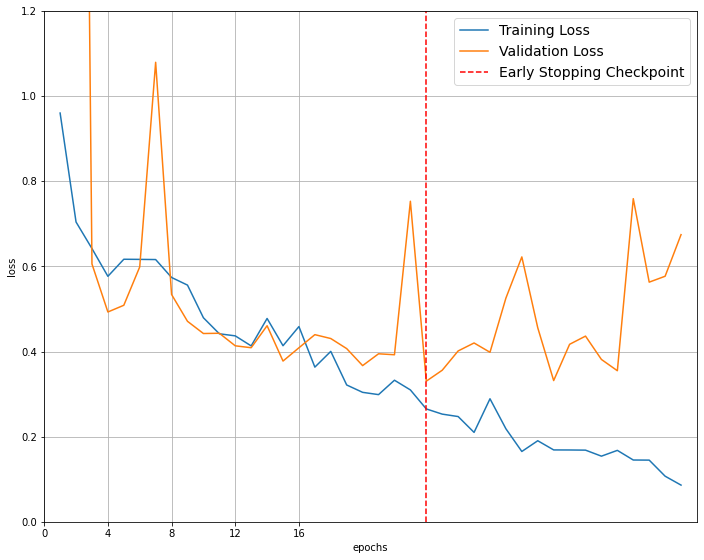

In [16]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
plt.rcParams["font.size"] = 14

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.xticks(np.arange(0, 20, 4) ) #start, end, 間隔
plt.yticks(np.arange(0, 1.4, 0.2) )
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.show()

#**GradCam**

In [17]:
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm

class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats) #out: [1,1000]
    c_score = out[0, c]   #c_scoreとは？？

    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0) #次元を1に引き延ばす
])

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      #print('Image: '+ image_name)
      label = os.path.basename(os.path.dirname(image_path))
      #print('Label: '+ label)
      return(image_name, label)

def gradcam(model_ft, test_dataset,  row=0, save=False):
    # Split model in two parts
    features_fn = nn.Sequential(*list(model_ft.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
    classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:])) #最終層の前にFlatten()を挿入
    #最後の2層

    #評価モードにする    
    model_ft = model_ft.eval()
    model_ft = model_ft.to(device)

    classes = ["cont", "grav"]

    #画像のパスを指定
    #for j in range(3):
    for j in range(len(test_dataset)):

        #元画像

        image = test_dataset[j][0]
        image = image.permute(1, 2, 0)

        img_tensor = test_dataset[j][0].unsqueeze(0)
        #Softmaxにかけたときの確率上位1つのpp(確率)とcc(class番号)を取得(tench→正常,goldfish→斜視)
        pp, cc = torch.topk(nn.Softmax(dim=1)(model_ft(img_tensor.to(device))), 1)

        #pとcを対にして入力
        for i, (p, c) in enumerate(zip(pp[0], cc[0])):  
            sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
            tmp = image.to('cpu').detach().numpy().copy()
            img = Image.fromarray((tmp*255).astype(np.uint8))
            #TensorをImageに変換
            sal = Image.fromarray(sal)
            sal = sal.resize(img.size, resample=Image.LINEAR)

            print()
            print('image: {}'.format(j))
            #print(img_path) #あとで参照しやすいように画像のパスを表示

            #plt.title('')
            print('label: '+classes[test_dataset[j][1]])
            print('pred:  '+'{}  {:.1f}%'.format(classes[c], 100*float(p)))
            #plt.title('pred:'+'{}: { .1f}%'.format(labels[c], 100*float(p)))        
            
            plt.figure(figsize=(15, 10))

            #グラフを1行2列に並べたうちの1番目
            plt.subplots_adjust(wspace=0,hspace=0)
            plt.subplot(1, 2, 1)
            plt.axis('off')
            plt.imshow(img)
            plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

            #元の画像を並べて表示
            image = test_dataset[j][0]
            image = image.permute(1, 2, 0)
            plt.subplot(1, 2, 2)
            plt.axis('off')
            plt.imshow(image)

            if save == True:
                plt.savefig(gradcam_folder_path+"/row{}-label{}-pred{}.png".format(row,classes[test_dataset[j][1]], classes[c]))
            row += 1

        plt.show()


#gradcam(model_ft, test_dataset, row=0, save=False)

#**Automated_analysis**

In [ ]:
#保存用の空CSVを作成
id, number, path, label = [], [], [], []

k=0
i=0
for j in test_dataset_grav:
    id.append(k)
    number.append(os.path.basename(j))
    path.append(j)
    label.append(1)
    k+=1
for j in test_dataset_cont:
    id.append(k)
    number.append(os.path.basename(j))
    path.append(j)
    label.append(0)
    k+=1


# k=0
# for i in val_dataset_grav:
#     for j in i:
#         fold.append(k)
#         number.append(os.path.basename(j))
#         path.append(j)
#         label.append(1)
#     k+=1
# k=0
# for i in val_dataset_cont:
#     for j in i:
#         fold.append(k)
#         number.append(os.path.basename(j))
#         path.append(j)
#         label.append(0)
#     k+=1
df_result = pd.DataFrame(index=[],columns=[])
df_result = pd.DataFrame(index=[],columns=["img_id", "img_number", "path","label", "pred", "prob"])
df_result["img_id"] = id
df_result["img_number"] = number
df_result["path"] = path
df_result["label"] = label

df_result

In [ ]:
########################################
#大事なデータを上書きしないよう注意！！#
########################################

df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) 

In [ ]:
#Open reslut_csv
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)
df_result

In [ ]:
#Start automated analysis
fold = 0

#Open reslut_csv
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)

time_start = time.perf_counter()


#Define Data Augumentation
TRAIN_RANDOM_ROTATION = 1
TRAIN_CROP_SCALE = (0.8,1.1)
PX = 224

train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


for fold in range(fold, num_folds): #指定したfold数から開始
    print("fold: {}".format(fold))
    train_list = train_dataset_grav[fold] + train_dataset_cont[fold]
    train_list_label = list(itertools.repeat(1, len(train_dataset_grav[fold])))+list(itertools.repeat(0, len(train_dataset_cont[fold])))
    val_list = val_dataset_grav[fold] + val_dataset_cont[fold]
    val_list_label = list(itertools.repeat(1, len(val_dataset_grav[fold])))+list(itertools.repeat(0, len(val_dataset_cont[fold])))
    test_list = test_dataset_grav + test_dataset_cont
    test_list_label = list(itertools.repeat(1, len(test_dataset_grav)))+list(itertools.repeat(0, len(test_dataset_cont)))

    #define dataset and dataloader
    train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
    val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
    test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)


    train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory=True, num_workers=0)


    # show sample image
    inputs, classes = next(iter(val_loader))
    print(classes)
    out = torchvision.utils.make_grid(inputs)
    class_names = ["cont", "grav"]
    imshow(out, title=[class_names[x] for x in classes])

    # model_ft = torchvision.models.resnet50(pretrained=True)  
    # num_ftrs = model_ft.fc.in_features
    # model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = torchvision.models.efficientnet_b4(pretrained = True)
    #model_ft = create_RepVGG_A2(deploy=False)
    #model_ft.load_state_dict(torch.load (pretrained_model_path))   
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

    #GPU使用
    model_ft = model_ft.to(device)

    #損失関数を定義
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    #https://blog.knjcode.com/adabound-memo/
    #https://pypi.org/project/torch-optimizer/
    from ranger_adabelief import RangerAdaBelief
    optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

    #optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min') 


    model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=20, num_epochs=300)


    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 1.0) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

    #Prediction for validation set
    
    model_ft.eval() # prep model for evaluation
    targets, probs, preds =[], [], []
    for image_tensor, target in test_loader:  
          #target = target.squeeze(1)     
          image_tensor = image_tensor.to(device)
          target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model_ft(image_tensor)
          _, pred = torch.max(output, 1) 
        
          prob = nn.Softmax(dim=1)(output) #calculate probalility
          prob = prob[0][1].cpu().detach() #probalility of being positive
          print(prob)
          print(pred) 
          
          probs.append(prob) #予測確率
          preds.append(int(pred))  #予測結果
          targets.append(int(target)) #ラベル
    y_label = np.array(targets)
    y_pred = np.array(preds)
    y_prob = np.array(probs)
    print("label")
    print(y_label)
    print("pred")
    print(y_pred)
    print("prob")
    print(y_prob)

    #write result to df
    row = 0
    if fold == 0:
        fold = 0
    else:
        for m in range(0, fold):
            row += len(test_dataset_grav[m]+test_dataset_cont[m])
    df_result.loc[row:row+len(y_pred)-1, "pred"] = y_pred
    column = fold + 9
    df_result.loc[row:row+len(y_pred)-1, "prob"] = y_prob
    df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) #save as csv
    
    #GradCam
    gradcam(model_ft, val_dataset, row, save=True) 

    #経過時間を表示
    time_end = time.perf_counter()
    time_elapsed = (time_end - time_start)
    print("Elapsed time: "+str(time_elapsed))

#**ROC curve**

In [ ]:
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)
df_result

Accuracy: 0.7205882352941176
26 8 11 23
confusion matrix = 
 [[23 11]
 [ 8 26]]
Accuracy : 0.7205882352941176
Precision (true positive rate) : 0.7027027027027027
Recall (sensitivity): 0.7647058823529411
Specificity : 0.6764705882352942
F1 score : 0.7323943661971832
Rand_state : 2
Area_under_ROC : 0.8330449826989619

        Normal  TED
Normal      23   11
TED          8   26


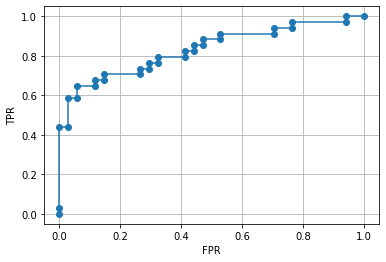

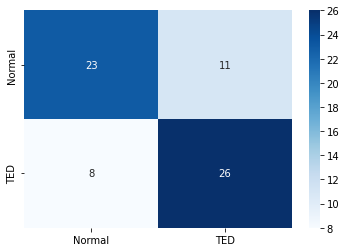

In [ ]:
import statistics
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

%matplotlib inline


#################################################
threshold = 0.5 #判定基準。ここは先に入力しておく
#################################################

accuracy = []
precision = []
recall = []
specificity = []
f1score = []
area_u_ROC = []

#TP_list, FN_list, FP_list, FN_list = [], [], [], []
#confusion_list = [[] for i in range(4)]  #[[TP],[FN],[FP],[FN]]
confusion_arr = np.zeros((2,2))


X = df_result["prob"]
Y = df_result["label"]

Y_pred_proba = X
Y_pred = np.where(Y_pred_proba >= threshold, 1, 0)

acc = accuracy_score(Y, Y_pred)
print('Accuracy:',acc)

tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
print(tp, fn, fp, tn)

#5-fold分のconfusion matrixを加算
confusion_arr += confusion_matrix(Y, Y_pred)


def specificity_score(label, pred):
    tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
    return tn / (tn + fp)

print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
print(f'Specificity : {specificity_score(Y, Y_pred)}')
print(f'F1 score : {f1_score(Y, Y_pred)}')


#ROC curve
fpr, tpr, thresholds = roc_curve(Y, Y_pred_proba)     
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
print(f'Area_under_ROC : {roc_auc_score(Y, Y_pred_proba)}')
#plt.savefig('plots/roc_curve.png')

# accuracy.append(accuracy_score(Y, Y_pred))
# precision.append(precision_score(Y, Y_pred))
# recall.append(recall_score(Y, Y_pred))
# specificity.append(specificity_score(Y, Y_pred))
# f1score.append(f1_score(Y, Y_pred))
# area_u_ROC.append(roc_auc_score(Y, Y_pred_proba))

print("")

#ヒートマップを作成
arr_2d = np.round(confusion_arr).astype(int) 
df_matrix = pd.DataFrame(data=arr_2d, index=["Normal", "TED"], columns=["Normal", "TED"])
print(df_matrix)

plt.figure()
sns.heatmap(df_matrix, annot=True,fmt="d", cmap='Blues')
plt.savefig(confusion_path, dpi=700)
plt.show()
plt.close('all')




In [ ]:
#ROC curve描き直し

def Draw_roc_curve(label_list_list, model_pred_prob_list, sample_num_list, num_curves):

#グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
    plt.legend(loc="lower right")
    plt.rcParams["font.family"] = "Helvetica"   # 使用するフォント
    plt.rcParams["font.size"] = 10 

    k=0
    for j in range(num_curves):
        y_score = []
        y_true = []

        for i in label_list_list[k]:
            if i == 1:
                  y_true.append(1)
            elif i == 0:
                  y_true.append(0)
            
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob_list[k]

        fpr,tpr,thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label= str(roc_label_list[k])+':ROC curve (area = %0.2f)' % roc_auc)
            
        k+=1

    plt.legend(loc="lower right")

    plt.savefig(ROC_path, format="png", dpi=700)

    plt.show()

    return fig

#Draw ROC curve
roc_label_list = [1]
fig = Draw_roc_curve([Y], [Y_pred_proba], roc_label_list, 1)



In [ ]:
#統計結果を追記
df_result['statistics'] = np.nan
df_result['result'] = np.nan
df_result.loc[0:5, 'statistics'] = ["Accuracy", "Positive predictive value", "Sensitivity", "Specificity", "F-score", "Area_under_ROC", "Rand_seed"]
df_result.loc[0:5, 'result'] = [accuracy_score(Y, Y_pred), precision_score(Y, Y_pred), recall_score(Y, Y_pred), specificity_score(Y, Y_pred), f1_score(Y, Y_pred), roc_auc_score(Y, Y_pred_proba), random_seed]

In [ ]:
df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) 
df_result

,img_id,img_number,path,label,pred,prob
0,0,4997.JPG,/content/drive/MyDrive/Deep_learning/666mai_da...,1,0,0.146510
1,1,1773.JPG,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.990127
2,2,6599.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.998215
3,3,19.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.987832
4,4,1682.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.556878
5,5,3077.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,0,0.268124
6,6,7104.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.999969
7,7,4331.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.998955
8,8,5906.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.999987
9,9,5397.jpg,/content/drive/MyDrive/Deep_learning/666mai_da...,1,1,0.999051
